# Exploratory Data Analysis
### Understanding the characteristics of the textual data itself. 
The goal is to identify patterns, anomalies, and necessary preprocessing steps before training a model.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from collections import Counter
from datasets import load_dataset
from itertools import combinations
from functools import reduce

In [2]:
# Loading dataset
recipes_df = load_dataset("json", data_files="../data/recipe.json")
df = recipes_df["train"].to_pandas()
df.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a b...","[3/4 cup ketchup, 1/2 cup beer, 1 tablespoon W...","[Combine ketchup, beer, Worcestershire sauce, ...",9,5
1,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,These gochujang pork belly bites are sweet and...,"[1 pound pork belly, 1/4 cup gochujang, 2 tabl...",[Preheat an air fryer to 400 degrees F (200 de...,5,4
2,3-Ingredient Air Fryer Everything Bagel Chicke...,Air Fryer Recipes,Air Fryer Recipes,These 3-ingredient air fryer everything bagel ...,"[1 ¼ pounds chicken tenders, 1 tablespoon oliv...",[Gather all ingredients. Preheat an air fryer ...,3,4
3,Air Fryer Everything Bagel Chicken Cutlets,Air Fryer Recipes,Air Fryer Recipes,These air fryer everything bagel chicken cutle...,"[4 chicken cutlets (about 1 pound total), salt...",[Preheat an air fryer to 400 degrees F (200 de...,9,9
4,Air Fryer Honey Sriracha Salmon Bites,Air Fryer Recipes,Air Fryer Recipes,These air fryer honey Sriracha salmon bites ar...,"[1 tablespoon soy sauce, 1 tablespoon honey, 1...",[Preheat an air fryer to 400 degrees F (200 de...,5,5


In [3]:
# Viewing content of first record
recipes_df["train"][0]

{'recipe_title': 'Air Fryer Potato Slices with Dipping Sauce',
 'category': 'Air Fryer Recipes',
 'subcategory': 'Air Fryer Recipes',
 'description': "These air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food somewhere between a French fry and a potato chip. Do take the time to make the dipping sauce—it's worth it.",
 'ingredients': ['3/4 cup ketchup',
  '1/2 cup beer',
  '1 tablespoon Worcestershire sauce',
  '1/2 teaspoon onion powder',
  '1/4 teaspoon cayenne',
  '2 baking potatoes',
  'olive oil cooking spray',
  '1/2 teaspoon garlic powder',
  'salt and freshly ground black pepper'],
 'directions': ['Combine ketchup, beer, Worcestershire sauce, onion powder, and cayenne in a small saucepan. Bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. Remove from heat, and cool. Cover and store in the refrigerator until ready to use.',
  'Preheat the air fryer to 400 degrees F (200 degrees C). Spray the basket with cooking spray or line w

In [4]:
# Number of rows and columns
df.shape

(62126, 8)

In [5]:
# Concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62126 entries, 0 to 62125
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     62126 non-null  object
 1   category         62126 non-null  object
 2   subcategory      62126 non-null  object
 3   description      62126 non-null  object
 4   ingredients      62126 non-null  object
 5   directions       62126 non-null  object
 6   num_ingredients  62126 non-null  int64 
 7   num_steps        62126 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


In [6]:
# Missing values
df.isna().sum()

recipe_title       0
category           0
subcategory        0
description        0
ingredients        0
directions         0
num_ingredients    0
num_steps          0
dtype: int64

In [7]:
# Descriptive statistics
df.describe()

,num_ingredients,num_steps
count,62126.000000,62126.000000
mean,9.017448,4.661865
std,3.830323,2.310253
min,1.000000,1.000000
25%,6.000000,3.000000
50%,9.000000,4.000000
75%,11.000000,6.000000
max,35.000000,25.000000


In [8]:
# Duplicates
duplicates_df = df[df.duplicated(keep=False, subset=["recipe_title", "description"])]
len(duplicates_df)

51460

In [9]:
# Inspecting records with their matching duplicates
duplicates_df.sort_values(by=["recipe_title", "description"])[0:9]

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
15989,"""Black Magic"" Chocolate Chip Cookies",Chocolate Chip Cookies,Chocolate Chip Cookies,"Chef John's ""black magic"" chocolate chip cooki...","[1 cup unsalted butter, soft, 1 cup white suga...","[Beat butter, white sugar, and brown sugar tog...",11,5
17650,"""Black Magic"" Chocolate Chip Cookies",Christmas Cookies,Chocolate Chip Cookies,"Chef John's ""black magic"" chocolate chip cooki...","[1 cup unsalted butter, soft, 1 cup white suga...","[Beat butter, white sugar, and brown sugar tog...",11,5
21250,"""Black Magic"" Chocolate Chip Cookies",Cookies,Chocolate Chip Cookies,"Chef John's ""black magic"" chocolate chip cooki...","[1 cup unsalted butter, soft, 1 cup white suga...","[Beat butter, white sugar, and brown sugar tog...",11,5
34013,"""Black Magic"" Chocolate Chip Cookies",Halloween,Halloween Cookies,"Chef John's ""black magic"" chocolate chip cooki...","[1 cup unsalted butter, soft, 1 cup white suga...","[Beat butter, white sugar, and brown sugar tog...",11,5
30851,"""CranCrack"" Cranberry Salad",Fruit Salads,Fruit Salads,"This was my mothers recipe, and named by my so...","[1 (12 ounce) package fresh cranberries, 1 lar...",[Process cranberries and orange in a food proc...,6,2
38999,"""CranCrack"" Cranberry Salad",Jell-O Salads,Jell-O Salads,"This was my mothers recipe, and named by my so...","[1 (12 ounce) package fresh cranberries, 1 lar...",[Process cranberries and orange in a food proc...,6,2
16570,"""Egg Not"" (Eggless Eggnog)",Christmas,Christmas Drink Recipes,I developed this recipe because of my love for...,"[5 cups milk, divided, ½ cup white sugar, 1 (3...","[Blend 2 cups milk, sugar, pudding mix, rum-fl...",7,1
17092,"""Egg Not"" (Eggless Eggnog)",Christmas,Eggnog,I developed this recipe because of my love for...,"[5 cups milk, divided, ½ cup white sugar, 1 (3...","[Blend 2 cups milk, sugar, pudding mix, rum-fl...",7,1
28350,"""Egg Not"" (Eggless Eggnog)",Eggnog,Eggnog,I developed this recipe because of my love for...,"[5 cups milk, divided, ½ cup white sugar, 1 (3...","[Blend 2 cups milk, sugar, pudding mix, rum-fl...",7,1


For each set of duplicates, we identified that the content is identical but has different categories and subcategories. This is because they've been classified across:
- Seasonal categories (Christmas, Halloween)
- Use-case categories (Cookies, Fruit salads)
- High-level categories (Desserts, Snacks)
- Ingredient-based categories (Eggnog category)

For a recipe recommendation system based on available ingredients,
- They do create redundancy and may bias similarity/recommendation scores.
- They also inflate the dataset artificially.
- Removing or consolidating them improves search, embeddings, clustering, and recall quality.

**We need a clean, unique recipe dataset.**

In [10]:
# Detecting duplicates across lists and strings, ignoring order and case
def normalize_column(col):
    """
    Normalize a column for duplicate detection:
    - Strings → lowercase, stripped
    - Lists/arrays → lowercase, stripped, sorted, converted to tuple
    """
    if isinstance(col, str):
        return col.strip().lower()
    elif isinstance(col, (list, np.ndarray)):
        # Lowercase each element, strip spaces, sort, convert to tuple
        cleaned = tuple(sorted([str(x).strip().lower() for x in col]))
        return cleaned
    return col

# Columns to check for duplicates
cols_to_check = ["recipe_title", "description", "ingredients", "directions"]

# Create normalized columns
normalized_cols = {col: df[col].apply(normalize_column) for col in cols_to_check}

# Combine into a DataFrame
norm_df = df.assign(**normalized_cols)

# Find duplicates
duplicates_norm_df = norm_df[norm_df.duplicated(subset=cols_to_check, keep=False)]

print(f"Number of duplicates: {len(duplicates_norm_df)}")

Number of duplicates: 51458


***Before normalization***
- Checked duplicates only on `["recipe_title", "description"]`.
- Result: 51,460 duplicates. This means that many recipes have identical titles and descriptions, ignoring ingredients and directions.
- Ingredients and directions weren't considered, so two recipes with the same title/description but different ingredients/directions would still count as duplicates.

***After normalization***
- Checked duplicates on `["recipe_title", "description", "ingredients", "directions"]`.
- Result: 51,458 duplicates.
- Why fewer? Only 2 recipes that had identical title+description actually differ in ingredients or directions.
- Normalization ensures lists are sorted and strings are lowercased and stripped
- So now duplicates are more strict and precise, not just title/description.

***What this tells us***
- Most duplicates were indeed exact duplicates in title/description, regardless of ingredients/directions.
- Only 2 cases have the same title/description but different ingredients/directions.

In [11]:
# Some aspects of the exploration will require using data that has no duplicates
deduplicated_df = norm_df.drop_duplicates(subset=["recipe_title", "description", "ingredients", "directions"])
deduplicated_df = deduplicated_df.copy()

In [12]:
# Concise summary of dataset
deduplicated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25024 entries, 0 to 62032
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     25024 non-null  object
 1   category         25024 non-null  object
 2   subcategory      25024 non-null  object
 3   description      25024 non-null  object
 4   ingredients      25024 non-null  object
 5   directions       25024 non-null  object
 6   num_ingredients  25024 non-null  int64 
 7   num_steps        25024 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 1.7+ MB


In [13]:
# Descriptive statistics
deduplicated_df.describe(include='all')

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
count,25024,25024,25024,25024,25024,25024,25024.000000,25024.000000
unique,24971,219,959,25015,24967,25013,NaN,NaN
top,best spinach dip ever,Appetizers And Snacks,Apple Pie,"a classic brunch cocktail, our diy variation p...","(cooking spray,)",(arrange rolls on the prepared baking sheets. ...,NaN,NaN
freq,2,1594,64,2,29,2,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,9.026455,4.321172
std,NaN,NaN,NaN,NaN,NaN,NaN,3.811175,2.174883
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,4.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,5.000000


## Category & Subcategory Analysis

In [14]:
# Number of categories
print(f"Number of categories in raw dataset: {df["category"].str.lower().nunique()}")

# Number of categories after removing duplicates
print(f"Number of categories in deduplicated dataset: {deduplicated_df["category"].str.lower().nunique()}")

Number of categories in raw dataset: 267
Number of categories in deduplicated dataset: 219


In [15]:
# Highest and lowest count per category
cat_counts1 = df["category"].value_counts()
cat_counts2 = deduplicated_df["category"].value_counts()

# df
top_category1 = cat_counts1.idxmax()
top_c_count1 = cat_counts1.max()
bottom_category1 = cat_counts1.idxmin()
bottom_c_count1 = cat_counts1.min()

# deduplicated_df
top_category2 = cat_counts2.idxmax()
top_c_count2 = cat_counts2.max()
bottom_category2 = cat_counts2.idxmin()
bottom_c_count2 = cat_counts2.min()

print("Raw dataset:")
print(f"Top Category: {top_category1} ({top_c_count1})")
print(f"Bottom Category: {bottom_category1} ({bottom_c_count1})")
print("\nDeduplicated dataset:")
print(f"Top Category: {top_category2} ({top_c_count2})")
print(f"Bottom Category: {bottom_category2} ({bottom_c_count2})")

Raw dataset:
Top Category: Main Dishes (3387)
Bottom Category: Waldorf Salads (2)

Deduplicated dataset:
Top Category: Appetizers And Snacks (1594)
Bottom Category: Divinity (1)


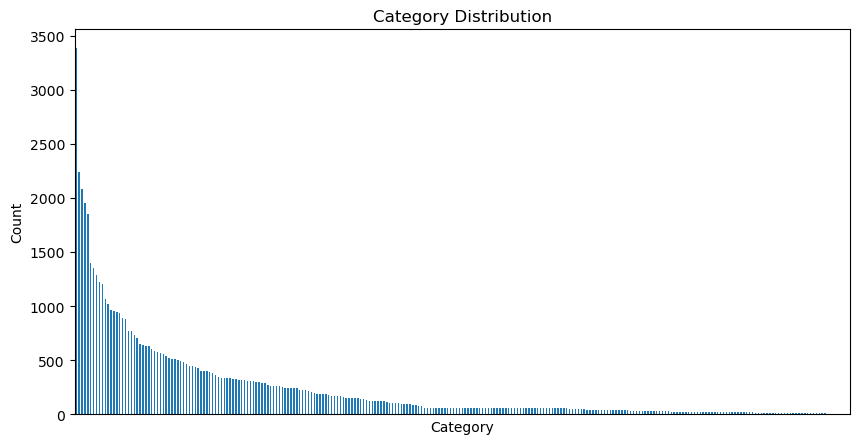

In [16]:
# Category distribution
plt.figure(figsize=(10,5))
df['category'].value_counts().plot(kind='bar')
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(ticks=[])
plt.show()

In [17]:
# Number of subcategories
print(f"Number of subcategories in raw dataset: {df["subcategory"].str.lower().nunique()}")

# Number of subcategories after removing duplicates
print(f"Number of subcategories in deduplicated dataset: {deduplicated_df["subcategory"].str.lower().nunique()}")

Number of subcategories in raw dataset: 1032
Number of subcategories in deduplicated dataset: 959


In [18]:
# Highest and lowest count per subcategory
subcat_counts1 = df["subcategory"].value_counts()
subcat_counts2 = deduplicated_df["subcategory"].value_counts()

# df
top_subcategory1 = subcat_counts1.idxmax()
top_sc_count1 = subcat_counts1.max()
bottom_subcategory1 = subcat_counts1.idxmin()
bottom_sc_count1 = subcat_counts1.min()

# deduplicated_df
top_subcategory2 = subcat_counts2.idxmax()
top_sc_count2 = subcat_counts2.max()
bottom_subcategory2 = subcat_counts2.idxmin()
bottom_sc_count2 = subcat_counts2.min()

print("Raw dataset:")
print(f"Top Category: {top_category1} ({top_sc_count1})")
print(f"Bottom Category: {bottom_category1} ({bottom_sc_count1})")
print("\nDeduplicated dataset:")
print(f"Top Category: {top_category2} ({top_sc_count2})")
print(f"Bottom Category: {bottom_category2} ({bottom_sc_count2})")

Raw dataset:
Top Category: Main Dishes (320)
Bottom Category: Waldorf Salads (1)

Deduplicated dataset:
Top Category: Appetizers And Snacks (64)
Bottom Category: Divinity (1)


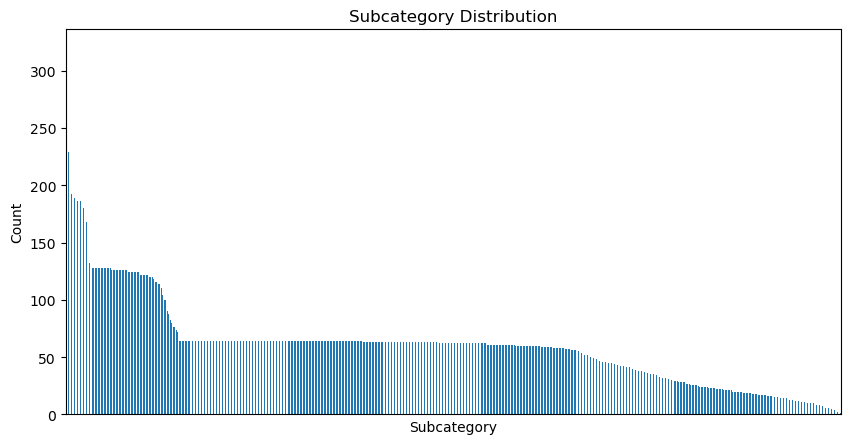

In [19]:
# Sub-category distribution
plt.figure(figsize=(10,5))
df['subcategory'].value_counts().plot(kind='bar')
plt.title("Subcategory Distribution")
plt.xlabel("Subcategory")
plt.ylabel("Count")
plt.xticks(ticks=[])
plt.show()

## Token Count in Recipe Title and Description

In [20]:
# Defining function to get length of tokens for recipe_title and description fields
nlp_tok = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])
# Some pipeline components were disbaled because we’re only counting tokens and checking if a token is punctuation, whitespace, or a stopword.
stopwords = nlp_tok.Defaults.stop_words

def spacy_cleaned_word_count(text):
    if not isinstance(text, str):
        return 0
    
    # Lowercasing helps spaCy handle tokens consistently
    doc = nlp_tok(text.lower())
    
    # Count tokens that are:
    # - not punctuation
    # - not whitespace
    # - not stopwords
    return sum(
        1 for token in doc
        if not token.is_punct
        and not token.is_space
        and token.text not in stopwords
    )

In [21]:
# Creating new fields containing the number of tokens
deduplicated_df["recipe_title_len"] = deduplicated_df["recipe_title"].apply(spacy_cleaned_word_count)
deduplicated_df["description_len"] = deduplicated_df["description"].apply(spacy_cleaned_word_count)

In [22]:
deduplicated_df.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps,recipe_title_len,description_len
0,air fryer potato slices with dipping sauce,Air Fryer Recipes,Air Fryer Recipes,"these air fryer potato slices, served with a b...","(1 tablespoon worcestershire sauce, 1/2 cup be...","(combine ketchup, beer, worcestershire sauce, ...",9,5,6,20
1,gochujang pork belly bites,Air Fryer Recipes,Air Fryer Recipes,these gochujang pork belly bites are sweet and...,"(1 pound pork belly, 1 tablespoon honey,, 1 te...","(meanwhile, for sauce, stir gochujang, soy sau...",5,4,4,20
2,3-ingredient air fryer everything bagel chicke...,Air Fryer Recipes,Air Fryer Recipes,these 3-ingredient air fryer everything bagel ...,"(1 tablespoon olive oil, 1 ¼ pounds chicken te...",(gather all ingredients. preheat an air fryer ...,3,4,7,40
3,air fryer everything bagel chicken cutlets,Air Fryer Recipes,Air Fryer Recipes,these air fryer everything bagel chicken cutle...,"(1 1/2 cups panko breadcrumbs, 2 large eggs, 2...",(add cutlets to the bag with flour. seal the b...,9,9,5,17
4,air fryer honey sriracha salmon bites,Air Fryer Recipes,Air Fryer Recipes,these air fryer honey sriracha salmon bites ar...,"(1 tablespoon honey, 1 tablespoon soy sauce, 1...",(cook in the preheated air fryer for 4 minutes...,5,5,6,35


In [23]:
# Maximum lenghts for recipe title and description
print(f"Maximum length for recipe title tokens {deduplicated_df["recipe_title_len"].max()}")
print(f"Maximum length for description tokens {deduplicated_df["description_len"].max()}")

Maximum length for recipe title tokens 13
Maximum length for description tokens 72


In [24]:
# Maximum lenghts for recipe title and description
print(f"Minimum length for recipe title tokens {deduplicated_df["recipe_title_len"].min()}")
print(f"Minimum length for description tokens {deduplicated_df["description_len"].min()}")

Minimum length for recipe title tokens 1
Minimum length for description tokens 1


***Visualizing token length distributions***

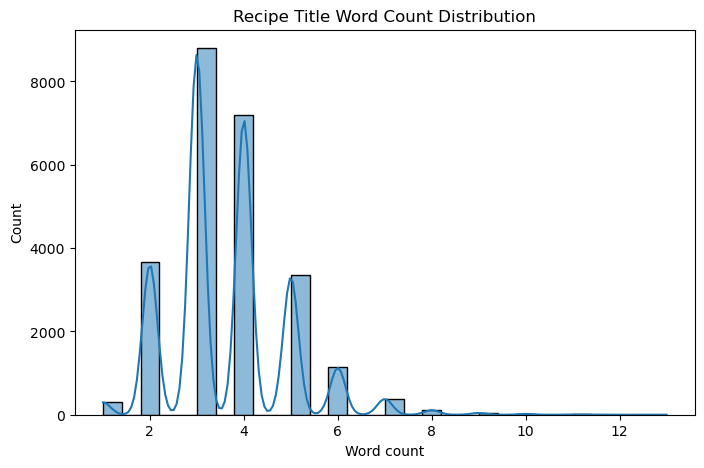

In [25]:
# Recipe Title Length
plt.figure(figsize=(8,5))
sns.histplot(deduplicated_df["recipe_title_len"], bins=30, kde=True)
plt.title("Recipe Title Word Count Distribution")
plt.xlabel("Word count")
plt.show()

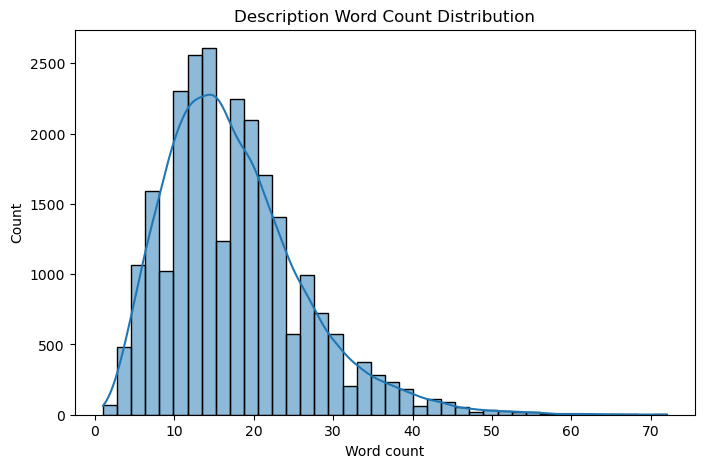

In [26]:
# Description length
plt.figure(figsize=(8,5))
sns.histplot(deduplicated_df["description_len"], bins=40, kde=True)
plt.title("Description Word Count Distribution")
plt.xlabel("Word count")
plt.show()

## 🥕 INGREDIENT-CENTRIC ANALYSIS

In [27]:
nlp = spacy.load("en_core_web_sm")  # for lemmatization

def clean_ingredient(ing):
    ing = ing.lower().strip()
    
    # 1. Remove quantities (fractions, decimals, integers)
    ing = re.sub(r'(\d+/\d+|\d+(\.\d+)?)', '', ing)
    
    # 2. Remove units
    units = ['cup', 'cups', 'tablespoon', 'tablespoons', 'tsp', 'teaspoon', 'teaspoons',
             'oz', 'ounce', 'ounces', 'lb', 'pound', 'pounds', 'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'small', 'large']
    pattern = r'\b(?:' + '|'.join(units) + r')\b'
    ing = re.sub(pattern, '', ing)
    
    # 3. Remove extra words often used for preparation
    prep_words = ['fresh', 'freshly', 'ground', 'minced', 'chopped', 'diced', 'sliced', 
                  'baking', 'cooking', 'spray', 'for garnish', 'to taste']
    pattern2 = r'\b(?:' + '|'.join(prep_words) + r')\b'
    ing = re.sub(pattern2, '', ing)
    
    # 4. Remove punctuation
    ing = re.sub(r'[^\w\s]', '', ing)
    
    # 5. Split compound ingredients like 'salt and pepper'
    parts = re.split(r'\band\b|\&', ing)
    parts = [p.strip() for p in parts if p.strip()]
    
    # 6. Lemmatize using SpaCy
    cleaned_parts = []
    for p in parts:
        doc = nlp(p)
        lemmas = [tok.lemma_ for tok in doc if tok.is_alpha]
        if lemmas:
            cleaned_parts.append(' '.join(lemmas))
    
    return cleaned_parts

# Apply to dataset
deduplicated_df['clean_ingredients'] = deduplicated_df['ingredients'].apply(lambda lst: [i for ing in lst for i in clean_ingredient(ing)])

# Preview
deduplicated_df[['ingredients', 'clean_ingredients']].head(10)

,ingredients,clean_ingredients
0,"(1 tablespoon worcestershire sauce, 1/2 cup be...","[worcestershire sauce, beer, garlic powder, on..."
1,"(1 pound pork belly, 1 tablespoon honey,, 1 te...","[pork belly, honey, ginger, gochujang, soy sauce]"
2,"(1 tablespoon olive oil, 1 ¼ pounds chicken te...","[olive oil, chicken tender, everything bagel s..."
3,"(1 1/2 cups panko breadcrumbs, 2 large eggs, 2...","[panko breadcrumb, egg, milk, ablespoon veryth..."
4,"(1 tablespoon honey, 1 tablespoon soy sauce, 1...","[honey, soy sauce, sriracha, rice vinegar, gra..."
5,"(1 teaspoon lime juice, 2 ears corn, shucked a...","[lime juice, ear corn shuck, halve, crumble co..."
6,"(1 lime, zested and juiced, 1 tablespoon fresh...","[lime zest, juice, ginger, soy sauce, sriracha..."
7,"(1 onion, 1/2 teaspoon cayenne pepper, 1/4 cup...","[onion, cayenne pepper, allpurpose flour, salt..."
8,"(1 pound baby carrots, 2 tablespoons butter,, ...","[baby carrot, butter, hot honey such as mike h..."
9,"(1 1/2 teaspoons olive oil, 1 large onion, sal...","[olive oil, onion, salt, black pepper]"


In [40]:
#  More detailed preview
deduplicated_df['clean_ingredients'][0:50]

0     [worcestershire sauce, beer, garlic powder, on...
1     [pork belly, honey, ginger, gochujang, soy sauce]
2     [olive oil, chicken tender, everything bagel s...
3     [panko breadcrumb, egg, milk, ablespoon veryth...
4     [honey, soy sauce, sriracha, rice vinegar, gra...
5     [lime juice, ear corn shuck, crumble cotija ch...
6     [lime zest, juice, ginger, soy sauce, sriracha...
7     [onion, cayenne pepper, all purpose flour, sal...
8     [carrot, butter, hot honey s hot honey, nonsti...
9                [olive oil, onion, salt, black pepper]
10    [manicotti pasta, tomato with green chile tel,...
11    [cinnamon, lemon juice, vanilla extract, confe...
12    [mustard, onion, can tuna, english muffin, cel...
13    [lemon zest, juice, mint, oregano, kosher salt...
14    [grape tomato, chicken breast, zucchini, feta ...
15    [salmon, olive oil, paprika, honey mustard, sa...
16    [salmon filet, honey, salt, black pepper, dijo...
17    [lime juice, salmon fillet, soy sauce, toa

***Ingredient frequency*** (using cleaned ingredients)

In [47]:
# List of all ingredients
all_clean_ingredients = [ing for lst in deduplicated_df["clean_ingredients"] for ing in lst]

ingredient_freq = Counter(all_clean_ingredients)

freq_df = pd.DataFrame(
    ingredient_freq.items(), 
    columns=["ingredient", "count"]
).sort_values("count", ascending=False)

print(freq_df.head(20))

            ingredient  count
8                 salt  11410
68         white sugar   7276
23   all purpose flour   5538
18                  to   5170
20                 egg   5017
81              garlic   4511
252              water   3934
9         black pepper   3697
47               onion   3684
65     vanilla extract   3583
15           olive oil   3581
50              butter   3312
21                milk   3111
63            cinnamon   2734
26     black pepper to   2666
171      vegetable oil   2518
201        bake powder   2416
40                need   2261
203          bake soda   2078
170        brown sugar   1806


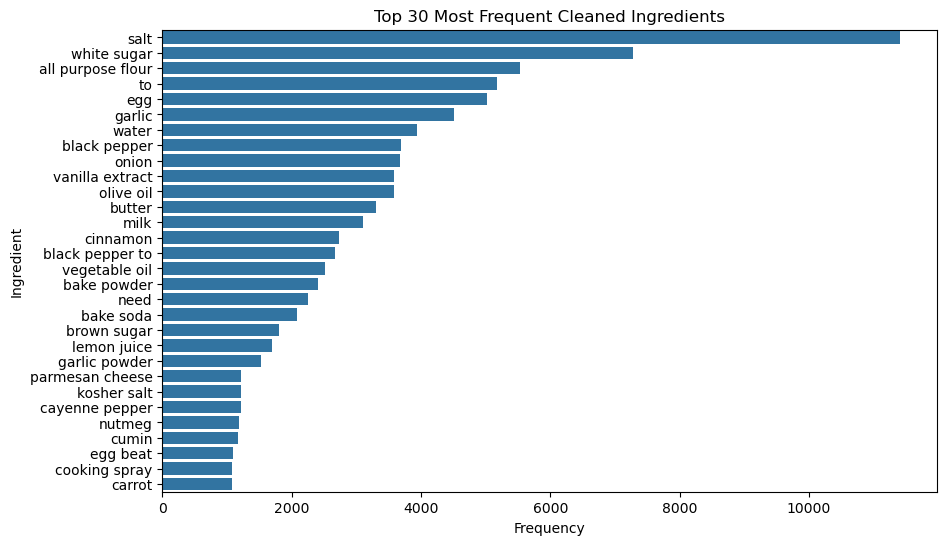

In [48]:
# Visualizing ingredient frequency
plt.figure(figsize=(10,6))
sns.barplot(
    data=freq_df.head(30),
    x="count", y="ingredient"
)
plt.title(f"Top 30 Most Frequent Cleaned Ingredients")
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
plt.show()

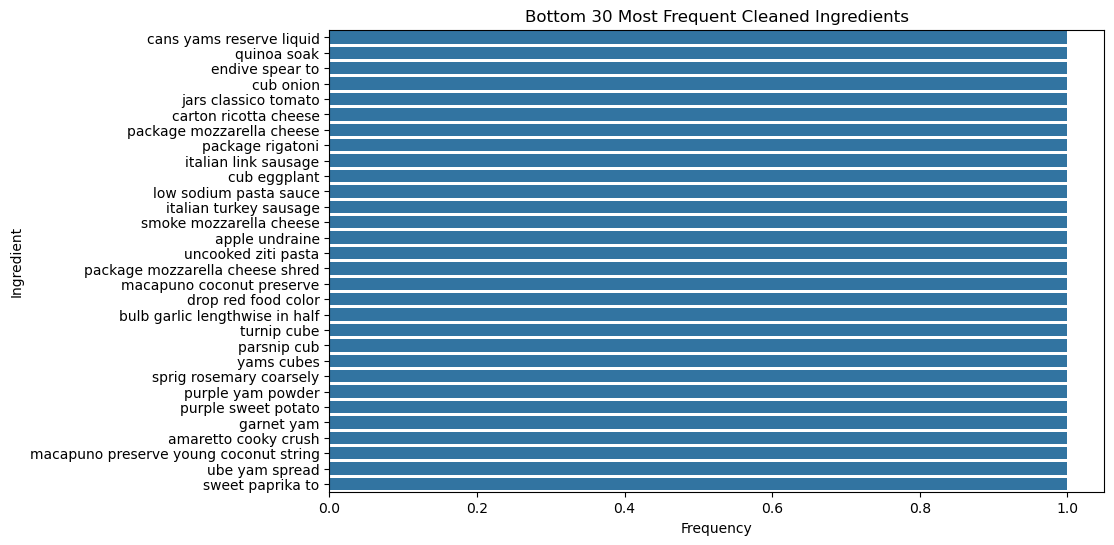

In [49]:
# Visualizing ingredient frequency
plt.figure(figsize=(10,6))
sns.barplot(
    data=freq_df.tail(30),
    x="count", y="ingredient"
)
plt.title(f"Bottom 30 Most Frequent Cleaned Ingredients")
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
plt.show()

In [50]:
# Number of ingredients that appear once
print(f"{freq_df[freq_df["count"] == freq_df["count"].min()].shape[0]} ingredients appear only once")

12240 ingredients appear only once


### Observation
There seem to be some descriptive terms in the ingredient field (e.g., 'finely shred mozzarella cheese', 'mashed purple sweet potato').

✔ Problem 1 — Units & quantities removed imperfectly  
Words like “tablespoon”, “teaspoon”, “very”, “the” combine after removal → “ablespoon verythe”

✔ Problem 2 — We didn't remove brand-specific descriptors  
Examples: “such as tyson”, “such as rotel”, “such as pillsbury”, “such as goya”, “johnsonville”

✔ Problem 3 — We didn’t remove preparation instructions  
Examples: “cut into wedges”,“pat dry”, “for garnish”, “if desired”, "divide", "thaw if frozen"

✔ Problem 4 — Compound ingredients remain un-split  
“assorted root vegetable carrot parsnip beet onion” , “salt pepper”

✔ Problem 5 — Fresh, whole, baby, medium, optional descriptors remain  
Words like: baby, medium, mini, whole, fresh, optional

### STRONGER INGREDIENT CLEANING VERSION (V2)

In [39]:
# COMMON WORDS TO REMOVE COMPLETELY (expanded)
REMOVE_WORDS = set("""
baby medium mini small large fresh freshly ground optional divided cooked raw prepared 
cut sliced chopped diced minced halved quartered grated trimmed pat dry thaw drained 
seeded peeled whole boneless skinless skin-on skin-on bone-in giblet remove
plus more into for garnish garnish extra more additional taste seed seedless
package bag box can jar bottle container such as about inch inches
""".split())

UNITS = set("""
cup cups tablespoon tablespoons tbsp teaspoon teaspoons tsp oz ounce ounces lb pound 
pounds gram grams kg kilogram kilograms pinch pint quart stick slice slices clove cloves 
""".split())

BRANDS = set("""
tyson goya pillsbury rotel johnsonville cheezit el pato patak ortega trader joe
""".split())

PREP_CONNECTORS = ["and", "&", "or", "/", ","]

def clean_ingredient_v2(raw):
    raw = raw.lower().strip()

    # Remove quantity numbers
    raw = re.sub(r'(\d+/\d+|\d+\.\d+|\d+)', ' ', raw)

    # Replace hyphens with spaces
    raw = raw.replace('-', ' ')

    # Remove brand markers like "such as X"
    raw = re.sub(r"such as [a-zA-Z ]+", " ", raw)

    # Remove unit words
    for u in UNITS:
        raw = re.sub(rf"\b{u}\b", " ", raw)

    # Remove leftover punctuation
    raw = re.sub(r"[^\w\s]", " ", raw)

    # Split on connectors
    tokens = re.split(r"\band\b|\bor\b|\/|\,", raw)

    cleaned_items = []

    for token in tokens:
        words = token.split()
        # Remove stop-type words
        words = [w for w in words 
                 if w not in REMOVE_WORDS 
                 and w not in BRANDS 
                 and w.isalpha()]

        if not words:
            continue

        # Lemmatize
        doc = nlp(" ".join(words))
        lemma_words = [t.lemma_ for t in doc if t.is_alpha]

        if lemma_words:
            cleaned_items.append(" ".join(lemma_words))

    return cleaned_items

# Apply to dataset
deduplicated_df["clean_ingredients"] = deduplicated_df["ingredients"].apply(
    lambda lst: [i for raw in lst for i in clean_ingredient_v2(raw)]
)

# Preview
deduplicated_df[['ingredients', 'clean_ingredients']].head(10)

,ingredients,clean_ingredients
0,"(1 tablespoon worcestershire sauce, 1/2 cup be...","[worcestershire sauce, beer, garlic powder, on..."
1,"(1 pound pork belly, 1 tablespoon honey,, 1 te...","[pork belly, honey, ginger, gochujang, soy sauce]"
2,"(1 tablespoon olive oil, 1 ¼ pounds chicken te...","[olive oil, chicken tender, everything bagel s..."
3,"(1 1/2 cups panko breadcrumbs, 2 large eggs, 2...","[panko breadcrumb, egg, milk, ablespoon veryth..."
4,"(1 tablespoon honey, 1 tablespoon soy sauce, 1...","[honey, soy sauce, sriracha, rice vinegar, gra..."
5,"(1 teaspoon lime juice, 2 ears corn, shucked a...","[lime juice, ear corn shuck, crumble cotija ch..."
6,"(1 lime, zested and juiced, 1 tablespoon fresh...","[lime zest, juice, ginger, soy sauce, sriracha..."
7,"(1 onion, 1/2 teaspoon cayenne pepper, 1/4 cup...","[onion, cayenne pepper, all purpose flour, sal..."
8,"(1 pound baby carrots, 2 tablespoons butter,, ...","[carrot, butter, hot honey s hot honey, nonsti..."
9,"(1 1/2 teaspoons olive oil, 1 large onion, sal...","[olive oil, onion, salt, black pepper]"


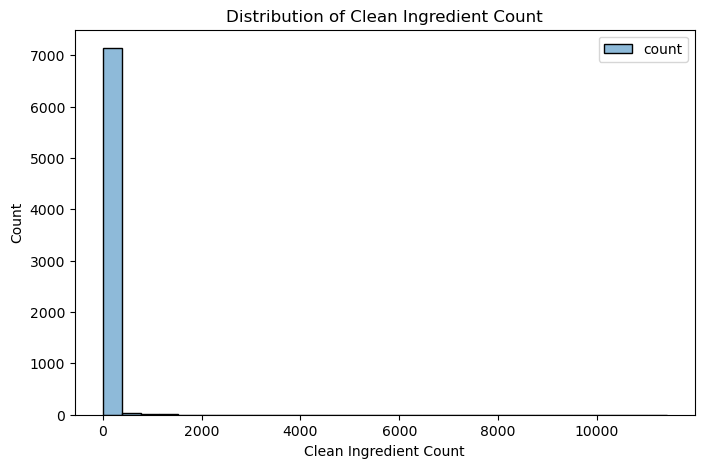

In [51]:
# Ingredient Count Distribution
plt.figure(figsize=(8,5))
sns.histplot(freq_df[freq_df["count"] > 1], bins=30)
plt.title("Distribution of Clean Ingredient Count")
plt.xlabel("Clean Ingredient Count")
plt.show()

***Vocabulary Quality Checks***

In [52]:
# Ckeck long ingredient names
freq_df[freq_df["ingredient"].str.len() > 20].head(20)

,ingredient,count
208,shred mozzarella cheese,482
251,unsweetene cocoa powder,481
676,semisweet chocolate chip,383
852,unsalted butter soften,315
1009,sweeten condense milk,280
2205,frozen whip topping thaw,209
89,crush red pepper flake,207
862,warm water degree f degree c,186
488,shred sharp cheddar cheese,181
1984,packages cream cheese soften,169


In [34]:
# Check if any entry still contains digits
freq_df[freq_df["ingredient"].str.contains(r"\d")].head()

,ingredient,count


***Ingredient Co-Occurrence Matrix*** (using cleaned ingredients)

In [53]:
N = 50
top_clean = freq_df.head(N)["ingredient"].tolist()

co_matrix = pd.DataFrame(0, index=top_clean, columns=top_clean)

for ing_list in deduplicated_df["clean_ingredients"]:
    ings = [i for i in ing_list if i in top_clean]
    for a, b in combinations(sorted(set(ings)), 2):
        co_matrix.at[a, b] += 1
        co_matrix.at[b, a] += 1

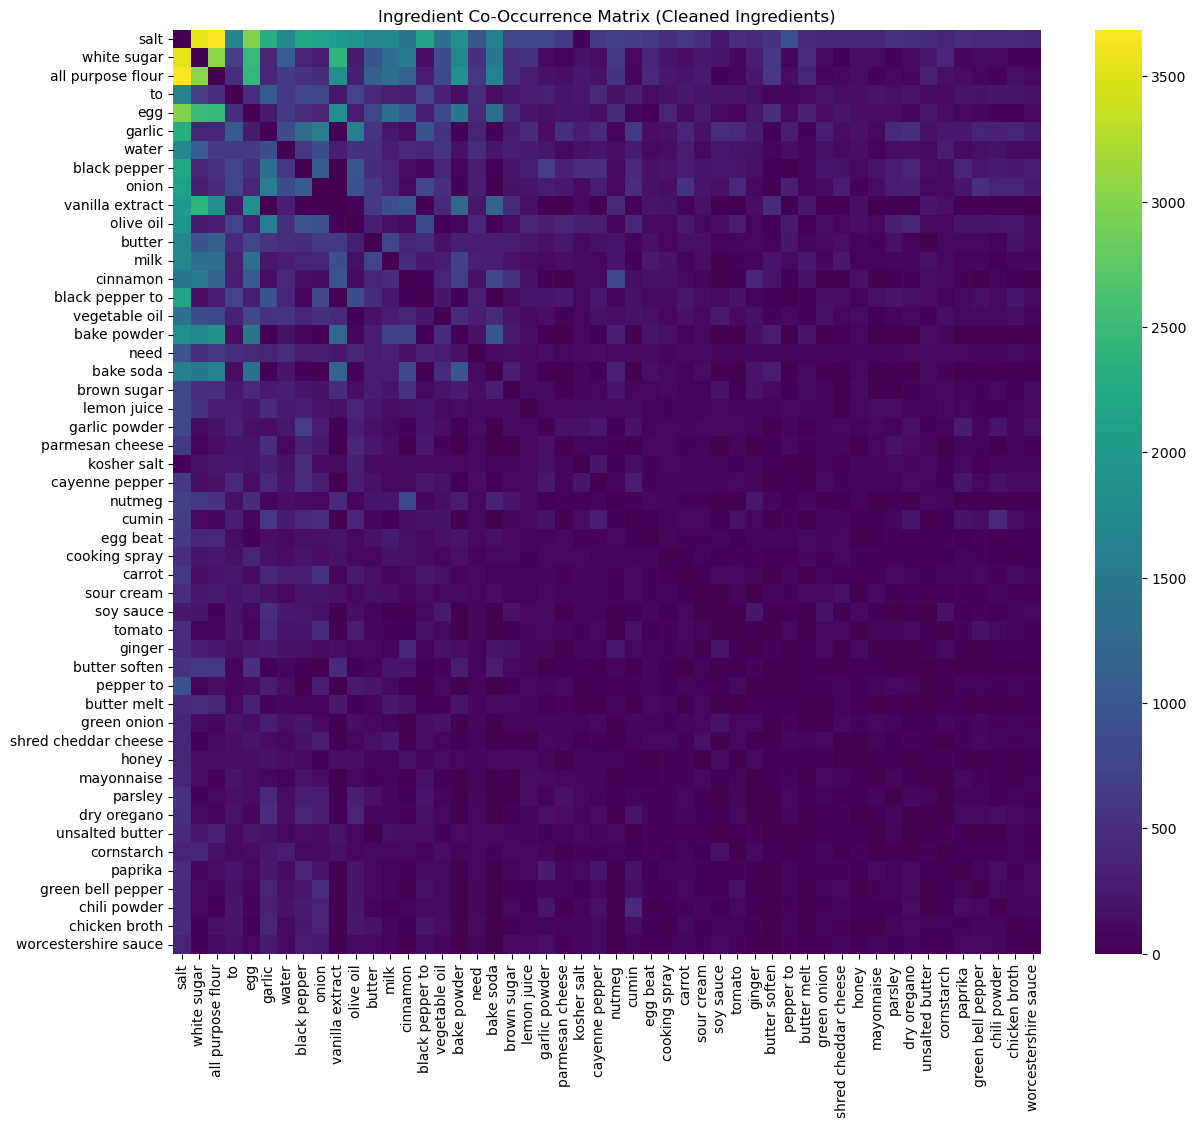

In [54]:
plt.figure(figsize=(14,12))
sns.heatmap(co_matrix, cmap="viridis")
plt.title("Ingredient Co-Occurrence Matrix (Cleaned Ingredients)")
plt.show()

***Ingredient-Category Relationship***

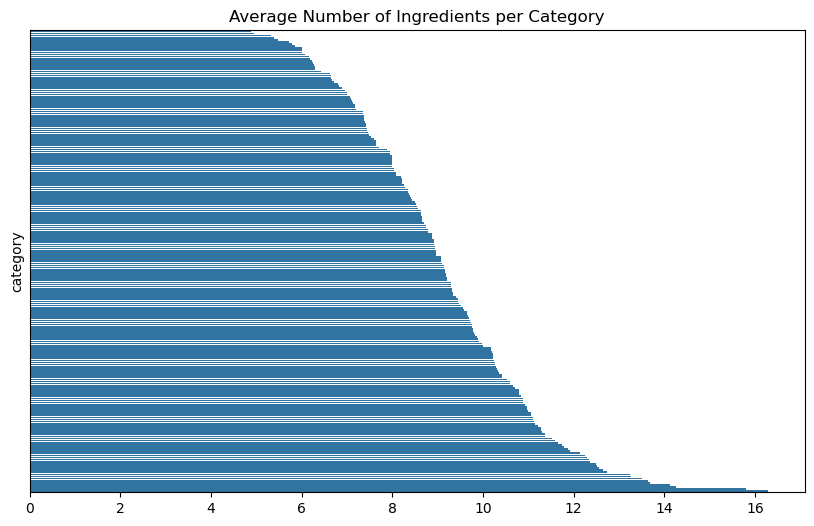

In [57]:
# Average number of ingredients per category:
cat_ing_avg = deduplicated_df.groupby("category")["num_ingredients"].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=cat_ing_avg.values, y=cat_ing_avg.index)
plt.title("Average Number of Ingredients per Category")
plt.yticks(ticks=[])
plt.show()

In [58]:
# Identify category-unique ingredients
exclusive = {}

for cat, group in deduplicated_df.groupby("category"):
    exclusive[cat] = set(
        ing for lst in group["clean_ingredients"] for ing in lst
    )

all_set = reduce(set.union, exclusive.values())

unique_by_cat = {
    cat: ings - reduce(set.union, [exclusive[c] for c in exclusive if c != cat])
    for cat, ings in exclusive.items()
}

# Example: ingredients unique to "Air Fryer Recipes"
unique_by_cat.get("Air Fryer Recipes", set())

{'ablespoon verythe bagel seasoning',
 'any color bell pepper',
 'apricot fruit spread',
 'assorted root vegetable carrot parsnip beet onion',
 'avocado oil nonstick cooking spray',
 'bacon each short piece',
 'bacon in half widthwise',
 'bag tortilla chip',
 'bagel season s everything but the bagel sesame seasoning blend',
 'black truffle sea salt',
 'brussels sprout brussels sprout',
 'bunchgreen onion green part only green onion green part only',
 'calamari ring pat',
 'cauliflower bite sized piece',
 'center salmon fillet chunk',
 'cheese cracker',
 'cheese see note',
 'chicken breast pat',
 'chicken cutlet total',
 'chicken taquito',
 'chicken tenderloin nugget size',
 'cilantro stem remove',
 'dill serve',
 'drizzle of buffalo wing sauce',
 'flakey salt to',
 'flat leafed parsley stems remove',
 'flour dust cake pan',
 'frozen bread crispy chicken strip',
 'frozen cauliflower tot',
 'frozen phyllo dough thaw',
 'frozen waffle',
 'fryer chicken giblet remove',
 'garlic flavor crou

## Things to consider for preprocessing...
1. Delete duplicates based on this subset `["recipe_title", "description", "ingredients", "directions"]`.
2. Rid ingredients of quantities (e.g., 3/4 cup, 1 tablespoon,...), units (cup, tablespoon, teaspoon,...), preparation descriptors (baking, cooking spray, freshly ground,...), and compound ingredients (salt and freshly ground black pepper)
3. Beyond what is described in point 2 above, there are some other descriptive terms. (For example, "egg at room temperature"). The terms captured in the ingredient normalization function would have to be updated. Also, could cooking instructions be found in the ingredient field?
4. 